In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
import os
import sys

import scipy as sp
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 경고 문구 off
import warnings
warnings.filterwarnings('ignore')

# 컬럼 표시 제한
# pd.set_option('display.max_row', None)
pd.set_option('display.max_columns', None)

/Users/jwmoon/miniforge3/envs/tf25/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/jwmoon/miniforge3/envs/tf25/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


# 1. 상황인식

- 목적

구내식당의 요일별 점심, 저녁식사를 먹는 인원을 예측


- 평가

평가산식 : MAE(Mean Absolute Error)
Public 평가 : 전체 Test 데이터 중 무작위 30 % (15일)
Private 평가 : 전체 Test 데이터 중 나머지 70 % (35일)


- 외부 데이터 및 사전학습 모델

공공 데이터와 같이 누구나 얻을 수 있고 법적 제약이 없는 외부 데이터 허용
사전학습 모델의 경우 사전학습에 사용된 데이터를 명시해야함
최종 평가시 외부데이터 및 출처 제출


- 코드 평가

      제목 양식 : 팀이름, Private 순위와 Private 점수, 모델 이름

      내 용 : 전처리, 학습, 후처리, 추론 일련의 과정을 담은 코드를 게시

      예시) 데이콘팀, Private 1위, Private 점수 : 5.23, ResNet

# 2. 데이터 분석

## 1) 데이터 불러오기

In [2]:
train_df = pd.read_csv('restaurant/train.csv')
train_df.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0


In [3]:
test_df = pd.read_csv('restaurant/test.csv')
test_df.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치


In [4]:
submission_df = pd.read_csv('restaurant/sample_submission.csv')
submission_df.head(1)

,일자,중식계,석식계
0,2021-01-27,0,0


## 2) 컬럼정리

In [5]:
train_df['일자'] = train_df['일자'].str.replace('-', '')
train_df.insert(0, 'date', train_df['일자'].str[2:8])
train_df.insert(1, 'year', train_df['일자'].str[:4])
train_df.insert(2, 'month', train_df['일자'].str[4:6])
train_df.insert(3, 'day', train_df['일자'].str[6:])
train_df.columns=['date','year','month','day','일자','요일','정원','휴가자','출장자','시간외근무자','재택근무자','조식','중식','석식','중식계','석식계']
train_df.insert(11, '근무중인원', train_df['정원']-train_df['휴가자']-train_df['출장자']+train_df['시간외근무자']-train_df['재택근무자'])
train_df['재택근무자'] = train_df['재택근무자'].astype(int)
train_df['중식계'] = train_df['중식계'].astype(int)
train_df['석식계'] = train_df['석식계'].astype(int)
train_df['근무중인원'] = train_df['근무중인원'].astype(int)

train_df.head(1)

,date,year,month,day,일자,요일,정원,휴가자,출장자,시간외근무자,재택근무자,근무중인원,조식,중식,석식,중식계,석식계
0,160201,2016,02,01,20160201,월,2601,50,150,238,0,2639,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1205 non-null   object
 1   year    1205 non-null   object
 2   month   1205 non-null   object
 3   day     1205 non-null   object
 4   일자      1205 non-null   object
 5   요일      1205 non-null   object
 6   정원      1205 non-null   int64 
 7   휴가자     1205 non-null   int64 
 8   출장자     1205 non-null   int64 
 9   시간외근무자  1205 non-null   int64 
 10  재택근무자   1205 non-null   int64 
 11  근무중인원   1205 non-null   int64 
 12  조식      1205 non-null   object
 13  중식      1205 non-null   object
 14  석식      1205 non-null   object
 15  중식계     1205 non-null   int64 
 16  석식계     1205 non-null   int64 
dtypes: int64(8), object(9)
memory usage: 160.2+ KB


In [7]:
test_df['일자'] = test_df['일자'].str.replace('-', '')
test_df.insert(0, 'date', test_df['일자'].str[2:8])
test_df.columns=['date','일자','요일','정원','휴가자','출장자','시간외근무자','재택근무자','조식','중식','석식']
test_df.insert(8, '근무중인원', test_df['정원']-test_df['휴가자']-test_df['출장자']+test_df['시간외근무자']-test_df['재택근무자'])
test_df['재택근무자'] = test_df['재택근무자'].astype(int)
test_df['근무중인원'] = test_df['근무중인원'].astype(int)

test_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무자,재택근무자,근무중인원,조식,중식,석식
0,210127,20210127,수,2983,88,182,5,358,2360,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    50 non-null     object
 1   일자      50 non-null     object
 2   요일      50 non-null     object
 3   정원      50 non-null     int64 
 4   휴가자     50 non-null     int64 
 5   출장자     50 non-null     int64 
 6   시간외근무자  50 non-null     int64 
 7   재택근무자   50 non-null     int64 
 8   근무중인원   50 non-null     int64 
 9   조식      50 non-null     object
 10  중식      50 non-null     object
 11  석식      50 non-null     object
dtypes: int64(6), object(6)
memory usage: 4.8+ KB


In [9]:
# sample_submission = pd.read_csv('restaurant/sample_submission.csv')
# sample_submission

## 3) 결측치 시각화

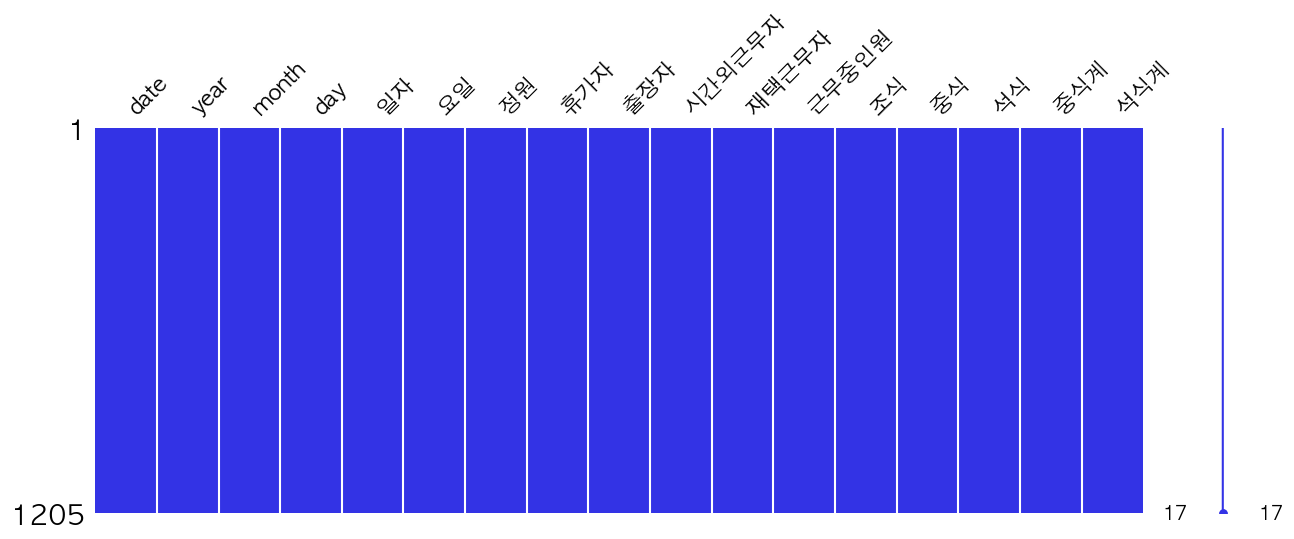

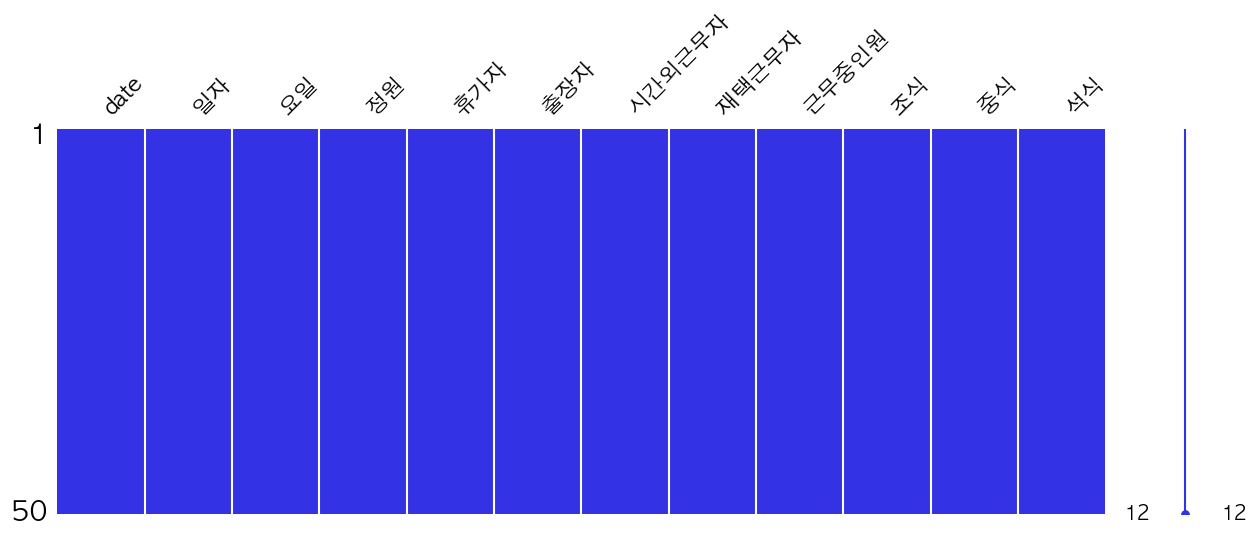

In [10]:
msno.matrix(df=train_df.iloc[:, :], color=(0.2, 0.2, 0.9), figsize=(15, 5))
msno.matrix(df=test_df.iloc[:, :], color=(0.2, 0.2, 0.9), figsize=(15, 5));

## 4) 텍스트 정리

In [11]:
import re

def split_text(stringData):

    text = re.sub(r'\([^)]*\)', repl='', string=stringData)        
    text = text.replace('/',' ')
    text = text.replace('  ',' ')
    text = text.replace('*',' ')
    return text

In [12]:
train_df['조식'] = train_df['조식'].apply(split_text)
train_df['중식'] = train_df['중식'].apply(split_text)
train_df['석식'] = train_df['석식'].apply(split_text)

test_df['조식'] = train_df['조식'].apply(split_text)
test_df['중식'] = train_df['중식'].apply(split_text)
test_df['석식'] = train_df['석식'].apply(split_text)

print(train_df['조식'][0])
print(train_df['중식'][0])
print(train_df['석식'][0])
print()
print(test_df['조식'][0])
print(test_df['중식'][0])
print(test_df['석식'][0]) 

모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치 
쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치 
쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치 

모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치 
쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치 
쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치 


In [13]:
morning_menu_list = []
lunch_menu_list = []
dinner_menu_list = []

for i in train_df['조식']:
    tmp_data = i.split(' ')
    #print(tmp_data)
    for j in tmp_data:
        morning_menu_list.append(j)
        
for i in train_df['중식']:
    tmp_data = i.split(' ')
    #print(tmp_data)
    for j in tmp_data:
        lunch_menu_list.append(j)
        
for i in train_df['석식']:
    tmp_data = i.split(' ')
    #print(tmp_data)
    for j in tmp_data:
        dinner_menu_list.append(j)
        
morning_menu_list[0]

'모닝롤'

In [14]:
type(morning_menu_list)

list

In [15]:
list(set(morning_menu_list))

['',
 '볼어묵볶음',
 '어묵토마토조림',
 '호박된장국',
 '매운버섯국',
 '옹심이만둣국',
 '오렌지빵',
 '대구찌개',
 '들깨무채국',
 '새우완자전',
 '쪽파숙회',
 '톳두부무침',
 '오이맛살냉채',
 '청포묵무침',
 '꽃게된장국',
 '건파래볶음',
 '호떡맥모닝',
 '황태국',
 '쥐포무침',
 '양념깻잎지',
 '롤케이크',
 '시금치프리타타',
 '새우완자국',
 '바지락무국',
 '야채햄샌드',
 '근대국',
 '단팥빵',
 '들깨감자국',
 '해물완자전',
 '바나나시나몬토스트',
 '오이보트샐러드',
 '미역레몬초무침',
 '닭죽',
 '콩나물간장조림',
 '베이컨숙주굴소스볶음',
 '옥수수샌드',
 '비트무생채',
 '해초무침',
 '감자국',
 '자반김',
 '매운어묵국',
 '겨울초겉절이',
 '카레감자채볶음',
 '메론빵',
 '오이도라지무침',
 '무비트생채',
 '발사믹드레싱',
 '홍합살무국',
 '두부계란전',
 '감자샌드',
 '가지두반장볶음',
 '실곤약흑임자무침',
 '마계토스트',
 '호떡',
 '물파래무침',
 '삼겹살김치볶음',
 '명엽체고추장볶음',
 '꽃게된장찌개',
 '미역나물',
 '가지양파나물',
 '오리훈제샌드위치',
 '브로컬리무침',
 '참나물무침',
 '흑임자죽',
 '김치황태국',
 '피바지락국',
 '들깨버섯국',
 '브로컬리들깨소스',
 '브로컬리죽',
 '오리엔탈D',
 '맑은만두육개장',
 '맑은연두부탕',
 '크루통크림스프',
 '브로컬리들깨무침',
 '참나물생채',
 '두부새우젓국',
 '새송이조림',
 '꿀호떡',
 '도토리묵무침',
 '참치야채죽',
 '민물새우찌개',
 '마늘쫑새우볶음',
 '쿠키',
 '섭산적조림',
 '땅콩샌드',
 '깍두기',
 '계란찜',
 '건포도머핀',
 '베이컨치즈베이글',
 '얼큰소고기국',
 '구이김',
 '후르츠팬케익',
 '땅콩소스',
 '양념장',
 '쥐어채무침',
 '호빵',
 '남친샌드위치',
 '치즈베이글',
 '새송이

In [16]:
len(morning_menu_list)

13507

In [17]:
len(list(set(morning_menu_list)))

787

In [18]:
lunch_menu_list[1]

'잡곡밥'

In [19]:
dinner_menu_list[2]

'육개장'

In [20]:
train_df.head()

,date,year,month,day,일자,요일,정원,휴가자,출장자,시간외근무자,재택근무자,근무중인원,조식,중식,석식,중식계,석식계
0,160201,2016,02,01,20160201,월,2601,50,150,238,0,2639,모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치,1039,331
1,160202,2016,02,02,20160202,화,2601,50,173,319,0,2697,모닝롤 단호박샌드 우유 두유 주스 계란후라이 팥죽 쌀밥 호박젓국찌개 시래기조림 포기김치,쌀밥 잡곡밥 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이,콩나물밥 양념장 어묵국 유산슬 아삭고추무침 바나나 포기김치,867,560
2,160203,2016,02,03,20160203,수,2601,56,180,111,0,2476,모닝롤 베이글 우유 두유 주스 계란후라이 표고버섯죽 쌀밥 콩나물국 느타리호박볶음 포...,카레덮밥 팽이장국 치킨핑거 쫄면야채무침 견과류조림 요구르트 포기김치,쌀밥 잡곡밥 청국장찌개 황태양념구이 고기전 새송이버섯볶음 포기김치,1017,573
3,160204,2016,02,04,20160204,목,2601,104,220,355,0,2632,모닝롤 토마토샌드 우유 두유 주스 계란후라이 닭죽 쌀밥 근대국 멸치볶음 포기김치,쌀밥 잡곡밥 쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트 포기김치,미니김밥 겨자장 우동 멕시칸샐러드 군고구마 무피클 포기김치,978,525
4,160205,2016,02,05,20160205,금,2601,278,181,34,0,2176,모닝롤 와플 우유 두유 주스 계란후라이 쇠고기죽 쌀밥 재첩국 방풍나물 포기김치,쌀밥 잡곡밥 떡국 돈육씨앗강정 우엉잡채 청경채무침 요구르트 포기김치,쌀밥 잡곡밥 차돌박이찌개 닭갈비 감자소세지볶음 콩나물무침 포기김치,925,330


In [21]:
lunch_bob1 = []
lunch_bob2 = []
lunch_soup = []
lunch_main1 = []
lunch_main2 = []
lunch_main3 = []

for i in range(len(train_df['중식'])):
    t1 = train_df['중식'][i]
    t2 = t1.split(' ')
    if len(t2) > 0:
        lunch_bob1.append(t2[0])
    else:
        lunch_bob1.append(None)

    if len(t2) > 1:
        lunch_bob2.append(t2[1])
    else:
        lunch_bob2.append(None)

    if len(t2) > 2:
        lunch_soup.append(t2[2])
    else:
        lunch_soup.append(None)

    if len(t2) > 3:
        lunch_main1.append(t2[3])
    else:
        lunch_main1.append(None)

    if len(t2) > 4:
        lunch_main2.append(t2[4])
    else:
        lunch_main2.append(None)
        
    if len(t2) > 4:
        lunch_main3.append(t2[5])
    else:
        lunch_main3.append(None)

train_df['lunch_bob1'] = lunch_bob1
train_df['lunch_bob2'] = lunch_bob2
train_df['lunch_soup'] = lunch_soup
train_df['lunch_main1'] = lunch_main1
train_df['lunch_main2'] = lunch_main2
train_df['lunch_main3'] = lunch_main3

In [22]:
dinner_bob1 = []
dinner_bob2 = []
dinner_soup = []
dinner_main1 = []
dinner_main2 = []
dinner_main3 = []

for i in range(len(train_df['석식'])):
    t1 = train_df['석식'][i]
    t2 = t1.split(' ')
    if len(t2) > 0:
        dinner_bob1.append(t2[0])
    else:
        dinner_bob1.append(None)

    if len(t2) > 1:
        dinner_bob2.append(t2[1])
    else:
        dinner_bob2.append(None)

    if len(t2) > 2:
        dinner_soup.append(t2[2])
    else:
        dinner_soup.append(None)

    if len(t2) > 3:
        dinner_main1.append(t2[3])
    else:
        dinner_main1.append(None)

    if len(t2) > 4:
        dinner_main2.append(t2[4])
    else:
        dinner_main2.append(None)
        
    if len(t2) > 4:
        dinner_main3.append(t2[5])
    else:
        dinner_main3.append(None)

train_df['dinner_bob1'] = dinner_bob1
train_df['dinner_bob2'] = dinner_bob2
train_df['dinner_soup'] = dinner_soup
train_df['dinner_main1'] = dinner_main1
train_df['dinner_main2'] = dinner_main2
train_df['dinner_main3'] = dinner_main3

## 5) 상관관계

### 상관관계 vs. 인과관계

상관관계(correlation)를 인과관계(causation)와 또는 인과관계를 예측하는 것과 혼동하지 않는 것이 중요하다. 변수 x는 변수 y를 예측할 때 유용할 수 있지만, 이것이 x가 y의 원인이 된다는 의미는 아니다. x가 y의 원인이 될 수 있지만, y가 x의 원인이 될 수도 있고, 또는 둘 사이의 관계는 단순한 인과관계보다 더 복잡할 수 있다.

예를 들면, 매달 해변 리조트에서 물에 빠져 죽은 횟수를 해당 기간에 팔린 아이스크림 수와 함께 모델링 할 수 있는데, 이 모델이 그럴듯한 예측값을 줄 수 있다. 그 이유는 아이스크림 때문에 물에 빠져 죽기 때문이 아니라, 더운 날에 사람들이 아이스크림을 더 많이 먹고 더운 날에 수영을 할 가능성도 높기 때문이다. 따라서 두 변수(아이스크림 판매량과 물에 빠져 죽는 것)가 상관관계가 있지만, 하나가 다른 하나의 원인인 것은 아니다. 두 가지 변수 모두 제 3의 변수인 기온이 원인이다. 이것이 바로 생략된 변수가 반응변수(response variable)와 적어도 하나 이상의 예측 변수(predictor variable) 모두에 영향을 미치는 “혼선(confounding)”의 예이다.

두 변수 사이에 상관관계가 없을 때나 모델과는 반대로 인과관계(causality)가 성립할 때도, 또는 혼선(confounding)이 있더라도, 상관관계(correlations)가 예측 작업에서는 유용하다는 것을 이해하는 것이 중요합니다.

하지만, 인과관계를 결정할 수 있으면, 종종 더 나은 모델이 가능합니다. 이 예제에서, 아이스크림 판매량과 물에 빠져 죽는 것은 온도와 해변 리조트에 방문하는 사람 숫자에 영향을 받을 것입니다. 다시 한번 강조하지만, 높은 기온 때문에 실제로 사람이 죽는 것은 아니지만, 이러한 변수는 사람이 왜 수영을 하는지와 더욱 직접적으로 관련이 있다. 따라서 물에 빠져 죽는 것에 대한 더 나은 모델에는 아마도 온도, 방문자 수가 들어가고 아이스크림 판매량이 빠질 것이다.

[1] https://otexts.com/fppkr/causality.html

### Q) 중식계와 석식계는 상관관계가 있는 것인가? 아니면 인과관계가 있는 것인가?

위에서 설명한 것처럼 구내식당 data의 변수를 놓고 상관관계와 인과관계에 대해 논의해 볼 수 있다. 중식계과 석식계을 제외한 나머지 변수(the rest)를 독립변수로 놓고, 중식계와 석식계를 종속변수로 놓자.

'시간외근무', '근무중인원' 등이 종속변수와 상관관계가 높은 변수들인데 이 변수들이 중식계에 영향을 미치고 또 석식계에 영향을 미친다고 해서, 중식계와 석식계가 하나가 다른 하나의 원인인 인과관계에 있는 것은 아니다. 두 변수는 상관관계가 있는 것이고 나머지 변수들이 이 두 변수의 원인인 것이다.


* 상관관계 : 중식계와 석식계

  - The rest는 중식계에 영향을 미친다. 

  - The rest는 석식계에 영향을 미친다.

  - → 중식계와 석식계는 상관관계가 있다.

In [23]:
train_df.head(0)

,date,year,month,day,일자,요일,정원,휴가자,출장자,시간외근무자,재택근무자,근무중인원,조식,중식,석식,중식계,석식계,lunch_bob1,lunch_bob2,lunch_soup,lunch_main1,lunch_main2,lunch_main3,dinner_bob1,dinner_bob2,dinner_soup,dinner_main1,dinner_main2,dinner_main3


In [24]:
train_df.corr()

,정원,휴가자,출장자,시간외근무자,재택근무자,근무중인원,중식계,석식계
정원,1.000000,0.244666,-0.061688,0.146544,0.452293,0.362927,-0.115529,-0.173852
휴가자,0.244666,1.000000,-0.273318,-0.230789,0.065397,-0.448198,-0.391975,-0.316894
출장자,-0.061688,-0.273318,1.000000,-0.308757,-0.352643,-0.150785,-0.512680,-0.188164
시간외근무자,0.146544,-0.230789,-0.308757,1.000000,0.156792,0.873177,0.535611,0.571168
재택근무자,0.452293,0.065397,-0.352643,0.156792,1.000000,0.034990,0.076509,-0.057534
근무중인원,0.362927,-0.448198,-0.150785,0.873177,0.034990,1.000000,0.529821,0.496586
중식계,-0.115529,-0.391975,-0.512680,0.535611,0.076509,0.529821,1.000000,0.508287
석식계,-0.173852,-0.316894,-0.188164,0.571168,-0.057534,0.496586,0.508287,1.000000


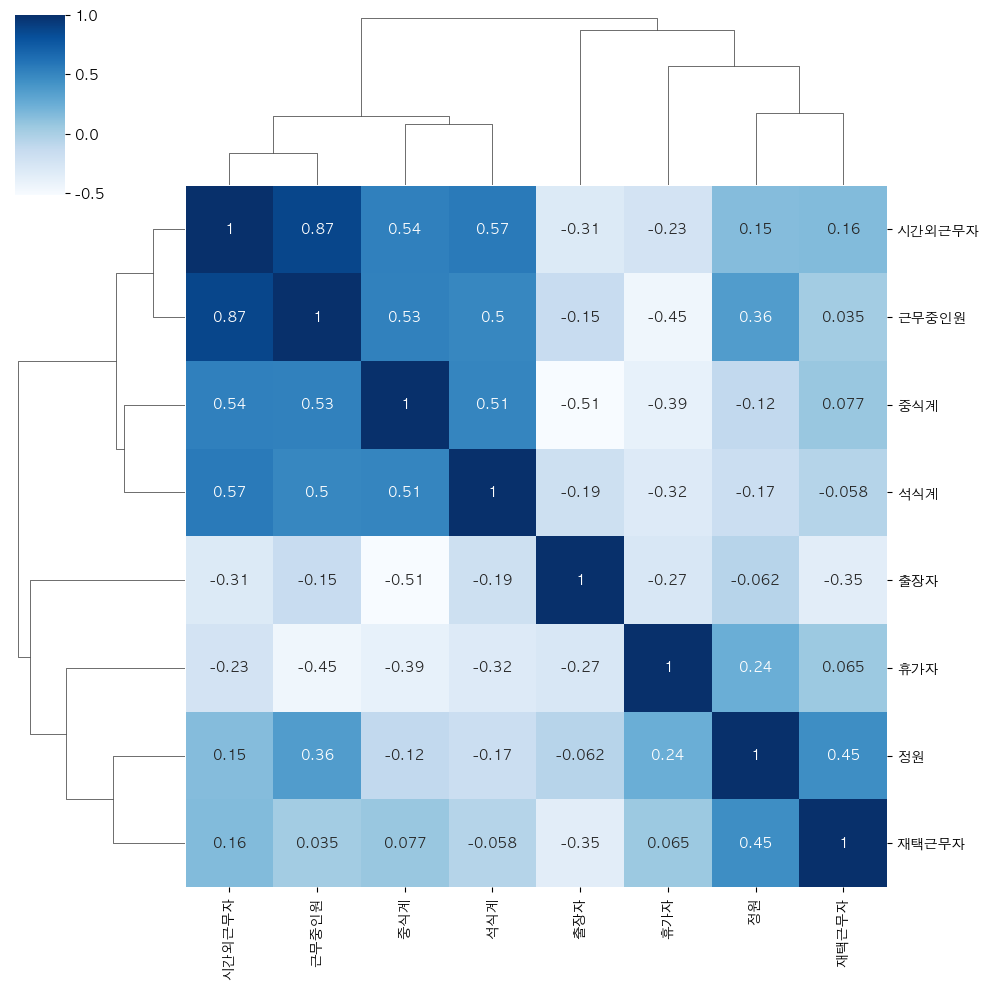

In [25]:
sns.clustermap(train_df.corr(), annot=True, cmap='Blues')
plt.show()

### 상관계수


시간외근무 → 중식계 (0.54)

근무중인원 → 중식계 (0.53)

___________________________________________________________________________________________________________________


시간외근무 → 석식계 (0.57)

근무중인원 → 석식계 (0.5)

___________________________________________________________________________________________________________________


석식계 - 중식계 (0.51)

# 2. 데이터 시각화

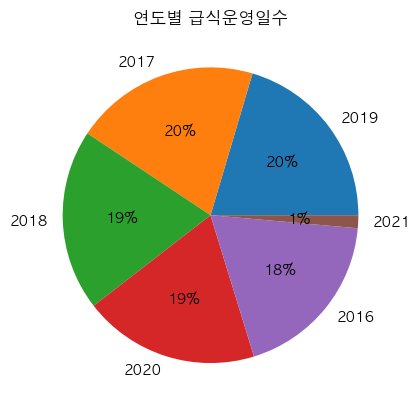

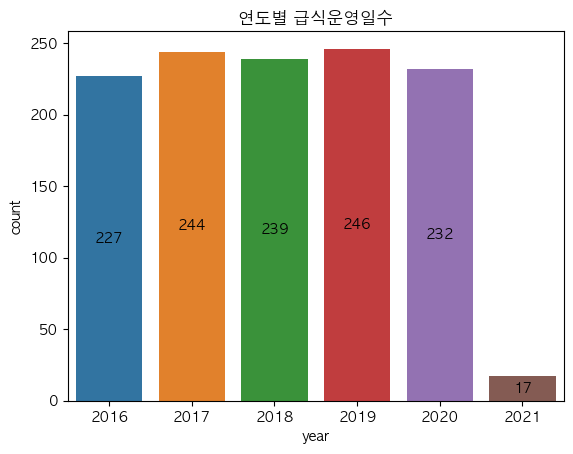

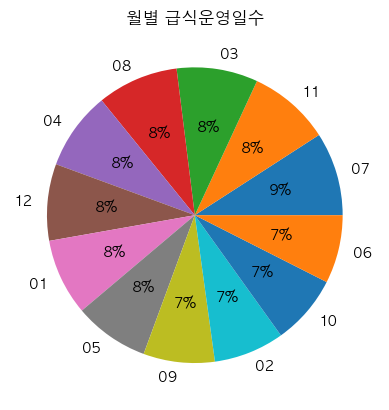

In [26]:
train_df["year"].value_counts()
plt.pie(train_df["year"].value_counts().values, labels=train_df["year"].value_counts().index, autopct="%d%%")
plt.title('연도별 급식운영일수')
plt.show()

ax = sns.countplot(x = 'year',data = train_df)
containers = ax.containers[0]
ax.bar_label(containers, labels=[f'{x:,.0f}' for x in containers.datavalues], label_type='center')
plt.title('연도별 급식운영일수')
plt.show()

train_df["month"].value_counts()
plt.pie(train_df["month"].value_counts().values, labels=train_df["month"].value_counts().index, autopct="%d%%")
plt.title('월별 급식운영일수')
plt.show()

## 급식 운영일수는 예측해야하는 2021년을 제외하고, 연도와 상관없이 분포가 고르게 되었음을 알 수 있다.

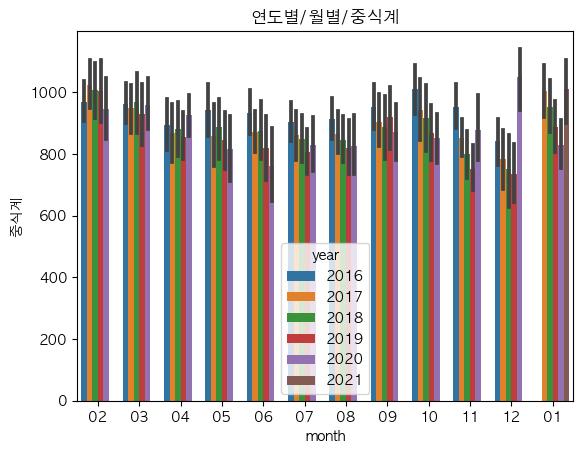

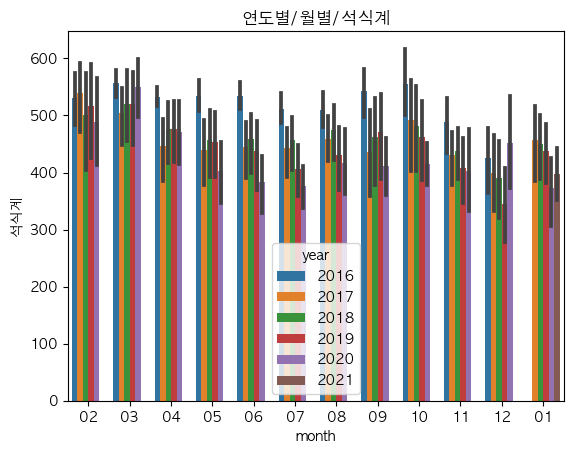

In [27]:
ax = sns.barplot(data=train_df, x='month', y="중식계", hue='year')
plt.title('연도별/월별/중식계')
plt.show()

ax = sns.barplot(data=train_df, x='month', y="석식계", hue='year')
plt.title('연도별/월별/석식계')
plt.show()

## 중식계와 석식계의 1년 통계는 비슷한 경향을 가지며, 6월, 12월에 적어지는것을 확인했다.

Text(0.5, 1.0, '요일별 중식계 평균값')

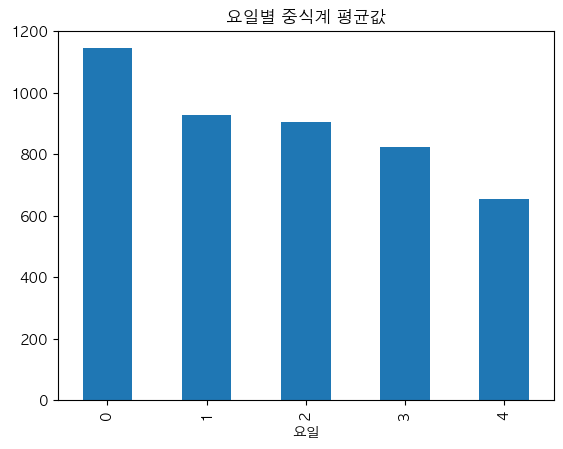

In [36]:
train_df.groupby('요일')['중식계'].mean().plot(kind='bar')
plt.title('요일별 중식계 평균값')

## 중식계는 max: 월, min : 금이고, 월 - 금 순으로 차차 줄어드는 경향이 있다.

Text(0.5, 1.0, '요일별 석식계 평균값')

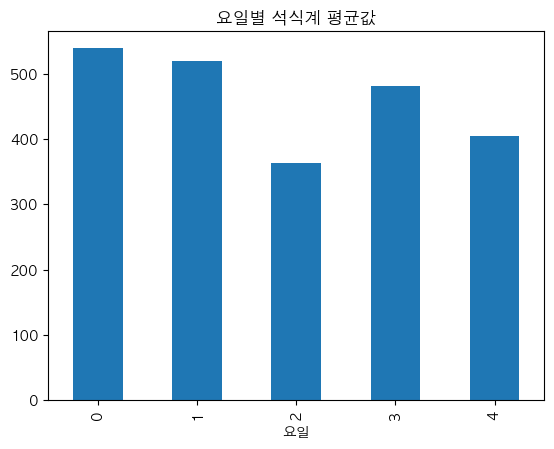

In [37]:
train_df.groupby('요일')['석식계'].mean().plot(kind='bar')
plt.title('요일별 석식계 평균값')

## 중식계는 max: 월, min : 수이고, 월,화,목,금,수 순으로 줄어드는 경향이 있다.

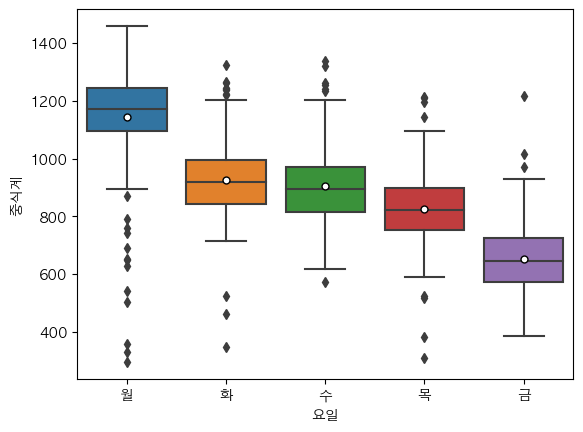

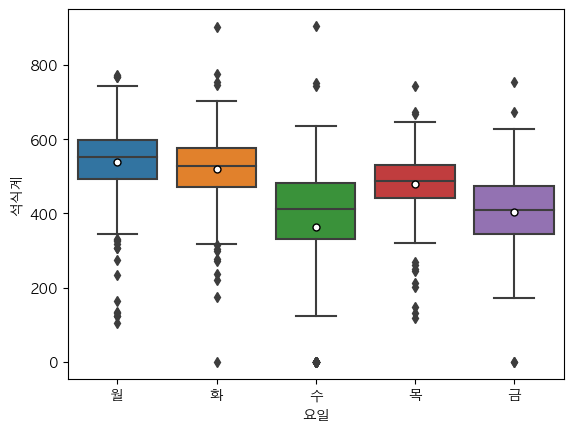

In [28]:
sns.boxplot(data=train_df, y="중식계", x="요일",showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})
plt.show()
sns.boxplot(data=train_df, y="석식계", x="요일",showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})
plt.show()

## 뭐라고 해야할지 모르겠어요 여기는,, 아니면 그래프 뺴도 될듯요 

In [29]:
train_df['중식'][1201]

# 조식은 조식계 없어서 뺴기, 쌀밥/덮밥여부, 요구르트,김치는 빼도될듯, 0과 1 이후인덱스는 무조건 국.

'쌀밥 수수밥 찰현미밥 냉이된장국 동파육 봄동전 청경채 버섯숙회 초장 무생채 양상추샐러드 파인D '

In [30]:
train_df.columns

Index(['date', 'year', 'month', 'day', '일자', '요일', '정원', '휴가자', '출장자',
       '시간외근무자', '재택근무자', '근무중인원', '조식', '중식', '석식', '중식계', '석식계',
       'lunch_bob1', 'lunch_bob2', 'lunch_soup', 'lunch_main1', 'lunch_main2',
       'lunch_main3', 'dinner_bob1', 'dinner_bob2', 'dinner_soup',
       'dinner_main1', 'dinner_main2', 'dinner_main3'],
      dtype='object')

In [31]:
train_df['요일'] = train_df['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})
test_df['요일'] = test_df['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})

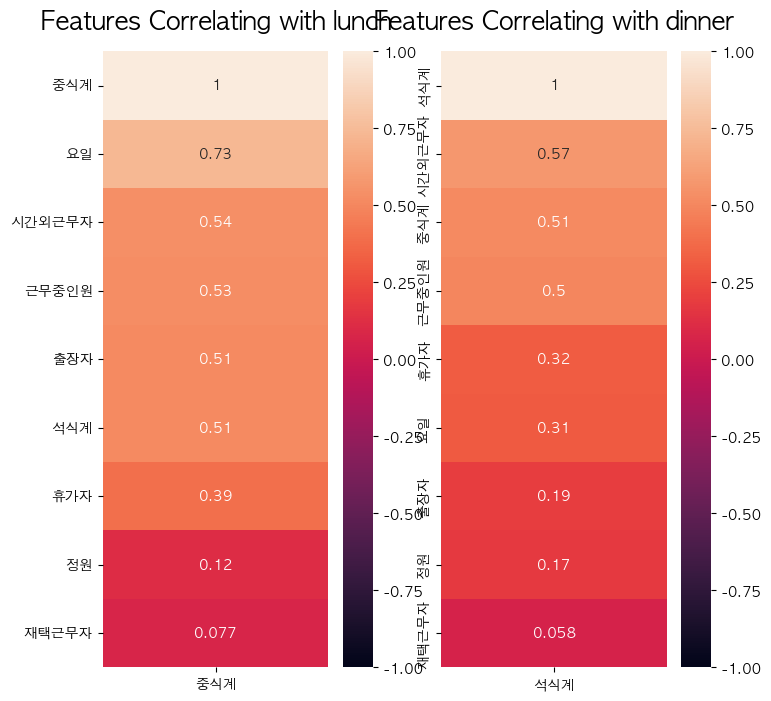

<Figure size 300x800 with 0 Axes>

In [32]:
figure, ((ax1,ax2)) = plt.subplots(nrows = 1, ncols = 2)
figure.set_size_inches (8, 8)

heatmap = sns.heatmap(train_df.corr().abs()[['중식계']].sort_values(by='중식계',ascending=False), vmin=-1, vmax=1,annot=True, ax=ax1)
heatmap.set_title('Features Correlating with lunch', fontdict={'fontsize':18}, pad=16);
plt.figure(figsize=(3, 8))
heatmap = sns.heatmap(train_df.corr().abs()[['석식계']].sort_values(by='석식계',ascending=False), vmin=-1, vmax=1,annot=True, ax=ax2)
heatmap.set_title('Features Correlating with dinner', fontdict={'fontsize':18}, pad=16);

## 중식계와 석식계의 corr 관계를 절대값으로 정렬하여 확인했다.

<AxesSubplot: xlabel='석식계', ylabel='중식계'>

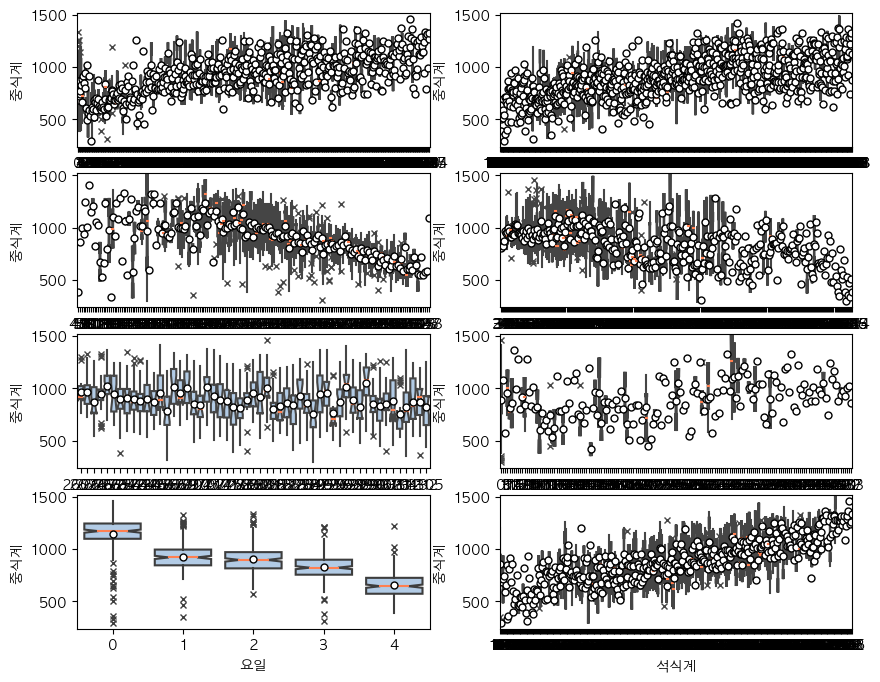

In [33]:
figure, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4, ncols=2)
figure.set_size_inches(10, 8)  

sns.boxplot(data=train_df, y="중식계", x="시간외근무자", ax=ax1,notch=True, showcaps=False,flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)}, medianprops={"color": "coral"},showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})
sns.boxplot(data=train_df, y="중식계", x="근무중인원", ax=ax2,notch=True, showcaps=False,flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)}, medianprops={"color": "coral"},showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})
sns.boxplot(data=train_df, y="중식계", x="출장자", ax=ax3,notch=True, showcaps=False,flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)}, medianprops={"color": "coral"},showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})
sns.boxplot(data=train_df, y="중식계", x="휴가자", ax=ax4,notch=True, showcaps=False,flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)}, medianprops={"color": "coral"},showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})
sns.boxplot(data=train_df, y="중식계", x="정원", ax=ax5,notch=True, showcaps=False,flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)}, medianprops={"color": "coral"},showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})
sns.boxplot(data=train_df, y="중식계", x="재택근무자", ax=ax6,notch=True, showcaps=False,flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)}, medianprops={"color": "coral"},showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})
sns.boxplot(data=train_df, y="중식계", x="요일", ax=ax7,notch=True, showcaps=False,flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)}, medianprops={"color": "coral"},showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})
sns.boxplot(data=train_df, y="중식계", x="석식계", ax=ax8,notch=True, showcaps=False,flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)}, medianprops={"color": "coral"},showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

# 이건 비례반비례 보려고 뽑은건데, 글씨가 너무 안보여서,, 그냥 대각선이 나오나 안나오나만 본거에요. 안예뻐서 빼도 상관없어욤

In [ ]:
# Boston dataset의 각 attribute에 선형회귀 적용하는 예제

import pandas as pd
from sklearn import datasets
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import datasets
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,35))
fig.suptitle('Cafetera dataset - (X:Y = each attr: total) with R2', fontsize=16, y=0.9)

data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
price = raw_df.values[1::2, 2]
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, price, test_size=0.2)

for i in range(x_train.shape[1]): # boston dataset에서 i번째 attribute(column)을 살펴볼 거에요.
    
    ### single attr: trainset / test_attr: testset ###
    # data는 전체 데이터셋입니다. 우리가 확인하고 싶은 건 trainset으로 훈련하고, testset으로 확인하는거죠!
    # 따라서 학습에 사용할 trainset, 예측과 평가에 사용할 testset은 따로 분리해야 할 것 같습니다.
    # 따라서 dataset이 아닌 x_train의 컬럼 데이터들을 불러와서 single attr에 넣어주면 좋을 것 같습니다.
    
    # 1. 데이터셋준비
    # X_train은 for문 돌려 컬럼별로 reshape하여 single_attr에 넣고, 이름은 컬럼명으로 넣고(이름은 나중에 그래프에 다 써야해서 받아놓는거임)
    # X_test는 컬럼별로 reshape만 해서 test_attr에 넣는다
    single_attr, attr_name = x_train[:, i].reshape(-1, 1), df.columns[i] # trainset, 컬럼명
    test_attr = x_test[:, i].reshape(-1, 1)# testset
    
    # 2. 학습
    # 선형회귀를 돌리는데, test는 학습하면 안되니 X_train을 reshape해놓은 single_attr와 y_train을 넣는다,
    estimator = LinearRegression()
    estimator.fit(single_attr, y_train) #모델의 학습은 trainset으로 해야하기 때문에 x_train, y_train으로 학습하면 좋을 것 같습니다.
    
    # 3. 예측
    # X_test를 reshape한 test_attr의 예측 y 값을 빼고,
    # r2 score를 이용해 선형회귀 모델이 적절한지 평가한다. (1일 수록 적절)
    pred_price = estimator.predict(test_attr)# predict 작업은 x_test로 하면 좋을 것 같습니다!
    score = metrics.r2_score(y_test, pred_price) # score도 test y값과 모델이 예측한 y값으로!!

    # 4. 시각화
    # 이 모든과정은 for문으로 각 컬럼별로 일어났고, 이를 모두 시각화한다.
    # scatter : x축 : X_train reshape한 single_attr / y축 : y_train
    # red line : x축 : X_test reshape한 test_attr / y축 : 예측한 test의 y값
    # 즉, 그래프는 train data x,y와 test data x,pred_y를 한번에 보여주고 있고, 
    # r2score는 제목으로 시각화함.
    
    # 캔버스 생성
    ax = fig.add_subplot(7, 2, i+1)
    ax.scatter(single_attr, y_train) # trainset에 대한 산포도
    ax.plot(test_attr, pred_price, color='red') # 우리 모델이 그린 추세선을 확인하고 싶은 거면 testset으로 하면 좋을 것 같아요.
    ax.set_title("{} x price, R2 score={:.3f}".format(attr_name ,score)) #subplot의 제목이에요
    ax.set_xlabel(attr_name) # x축
    ax.set_ylabel('price') # y축

In [34]:
# fig, ax = plt.subplots(figsize=(15,15) )

# mask = np.zeros_like(train_df.corr(), dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# sns.heatmap(train_df.corr(), 
#             cmap = 'gray', 
#             mask=mask,               # 표시하지 않을 마스크 부분을 지정
#             linewidths=.5,           # 경계면 실선으로 구분하기
#             cbar_kws={"shrink": .5}, # 컬러바 크기 절반으로 줄이기
#             vmin = -1,vmax = 1       # 컬러바 범위 -1 ~ 1
#            )  
# plt.show()      

# 실행안됨! module 'numpy' has no attribute 'bool'

In [ ]:
fig, ax = plt.subplots( figsize=(30,10) )
ax = sns.barplot(data=train_df, x='date', y="중식계")
plt.xticks(rotation = 90, fontsize=10)
plt.show()
fig, ax = plt.subplots( figsize=(30,10) )
ax = sns.lineplot(data=train_df, x='date', y="중식계")
plt.xticks(rotation = 90, fontsize=10)
plt.show()
fig, ax = plt.subplots( figsize=(30,10) )
ax = sns.barplot(data=train_df, x='date', y="석식계")
plt.xticks(rotation = 90, fontsize=10)
plt.show()
fig, ax = plt.subplots( figsize=(30,10) )
ax = sns.lineplot(data=train_df, x='date', y="석식계")
plt.xticks(rotation = 90, fontsize=10)
plt.show()

# 3. Model 설계

## (1) Average Blending

In [51]:
train_df.head(0)

,date,year,month,day,일자,요일,정원,휴가자,출장자,시간외근무자,재택근무자,근무중인원,조식,중식,석식,중식계,석식계,lunch_bob1,lunch_bob2,lunch_soup,lunch_main1,lunch_main2,lunch_main3,dinner_bob1,dinner_bob2,dinner_soup,dinner_main1,dinner_main2,dinner_main3


In [52]:
test_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무자,재택근무자,근무중인원,조식,중식,석식
0,210127,20210127,2,2983,88,182,5,358,2360,모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치


In [53]:
train = train_df.copy()
test = test_df.copy()
submission = submission_df.copy()

In [54]:
x_train = train[['요일', '정원', '휴가자', '출장자', '시간외근무자', '재택근무자', '근무중인원']]
y1_train = train['중식계']
y2_train = train['석식계']

x_test = test[['요일', '정원', '휴가자', '출장자', '시간외근무자', '재택근무자', '근무중인원']]

In [55]:
x_train.head()

,요일,정원,휴가자,출장자,시간외근무자,재택근무자,근무중인원
0,0,2601,50,150,238,0,2639
1,1,2601,50,173,319,0,2697
2,2,2601,56,180,111,0,2476
3,3,2601,104,220,355,0,2632
4,4,2601,278,181,34,0,2176


In [56]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   요일      1205 non-null   int64
 1   정원      1205 non-null   int64
 2   휴가자     1205 non-null   int64
 3   출장자     1205 non-null   int64
 4   시간외근무자  1205 non-null   int64
 5   재택근무자   1205 non-null   int64
 6   근무중인원   1205 non-null   int64
dtypes: int64(7)
memory usage: 66.0 KB


In [57]:
gboost = GradientBoostingRegressor(random_state=42)
xgboost = xgb.XGBRegressor(random_state=42)
lightgbm = lgb.LGBMRegressor(random_state=42)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'}, 
          {'model':lightgbm, 'name':'LightGBM'}]

### 교차검증

In [58]:
def get_cv_score(models):
    kfold = KFold(n_splits=10).get_n_splits(x_train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x_train.values, y=y1_train, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
        
get_cv_score(models)

Model: GradientBoosting, CV score:0.7497
Model: XGBoost, CV score:0.7073
Model: LightGBM, CV score:0.7160


In [59]:
def get_cv_score(models):
    kfold = KFold(n_splits=10).get_n_splits(x_train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x_train.values, y=y2_train, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
        
get_cv_score(models)

Model: GradientBoosting, CV score:0.2310
Model: XGBoost, CV score:0.0938
Model: LightGBM, CV score:0.1526


In [60]:
# 중식계 예측

def AveragingBlending(models, train, y, test):
    for m in models : 
        m['model'].fit(train.values, y)
    
    predictions = np.column_stack([m['model'].predict(test.values) for m in models])
    return np.mean(predictions, axis=1)

y1_pred = AveragingBlending(models, x_train, y1_train, x_test)
print(len(y1_pred))
y1_pred

50


array([1051.81457709,  976.39651549,  594.73437624, 1210.04771861,
       1036.2583523 ,  979.95787467,  899.25486805,  630.85967893,
       1215.4035108 , 1049.96475859,  729.34864459, 1214.66283979,
       1061.62987052, 1067.9848615 ,  817.97433379,  621.64719472,
       1172.54161584,  953.45899849,  807.95258423,  794.83456448,
        577.9774717 , 1056.81197486,  982.24994631,  882.53103947,
        624.01112888, 1290.58950878, 1161.25661062, 1027.59018786,
        905.66513203,  655.86496723, 1246.04486212, 1041.70261316,
       1045.72984285,  895.67796454,  588.41485459, 1208.67814377,
        994.50253358,  866.30200893,  789.96198651,  549.57258472,
       1187.58316455, 1043.77478715,  938.37848426,  789.19016935,
        583.57700325, 1177.71295617, 1029.65874715,  937.84034363,
        869.85170124,  601.53044863])

In [61]:
# 석식계 예측

def AveragingBlending(models, train, y, test):
    for m in models : 
        m['model'].fit(train.values, y)
    
    predictions = np.column_stack([m['model'].predict(test.values) for m in models])
    return np.mean(predictions, axis=1)

y2_pred = AveragingBlending(models, x_train, y2_train, x_test)
print(len(y2_pred))
y2_pred

50


array([380.81671725, 420.30245357, 253.74670322, 512.67398114,
       434.10957005, 434.57196315, 463.72819217, 328.13691967,
       581.24237023, 484.83850464, 235.60219178, 724.24236756,
       590.28117624, 365.12010901, 496.03976637, 332.06284237,
       646.07932376, 597.2705876 , 363.58517413, 471.86903591,
       275.2576914 , 658.0889434 , 397.28377823, 507.29743974,
       370.09742414, 656.87495997, 665.81476267, 378.24901156,
       489.26243684, 307.32555406, 675.64899483, 517.79831869,
       381.92430072, 430.2787023 , 263.32266724, 601.27842802,
       528.61044424, 413.07628269, 403.51796033, 281.29959757,
       582.01109606, 521.35530512, 415.80601418, 389.00830638,
       301.51910398, 567.88863604, 518.94347815, 389.86852889,
       429.12818241, 308.95069667])

## (2) Hyper Parameter Tuning

### MAE 계산

In [62]:
def mae (y_test, y_pred):
    return np.mean(np.abs(y_test-y_pred))
  
random_state=42

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [63]:
# 네 가지의 모델에 대해 모두 MAE값을 얻을 수 있도록 함수로 만들기 

def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=2022, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df[model_name] = mae(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['MAE']).T.sort_values('MAE', ascending=False)       
    return score_df

### 그리드 서치

In [64]:
def my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=-1):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    return results

In [65]:
# 중식계

param_grid = {'n_estimators': [50, 100], 'max_depth': [1, 5, 10], 'min_samples_leaf': [5, 10, 15], 'min_samples_split': [10, 20]}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, x_train, y1_train, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,max_depth,min_samples_leaf,min_samples_split,n_estimators,score,RMSLE
24,10,5,10,50,-11340.589249,106.492203
26,10,5,20,50,-11340.589249,106.492203
32,10,15,10,50,-11340.589249,106.492203
34,10,15,20,50,-11340.589249,106.492203
30,10,10,20,50,-11340.589249,106.492203
28,10,10,10,50,-11340.589249,106.492203
20,5,15,10,50,-11604.147717,107.722550
18,5,10,20,50,-11604.147717,107.722550
16,5,10,10,50,-11604.147717,107.722550
14,5,5,20,50,-11604.147717,107.722550


In [66]:
# 석식계

param_grid = {'n_estimators': [50, 100], 'max_depth': [1, 5, 10], 'min_samples_leaf': [5, 10, 15], 'min_samples_split': [10, 20]}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, x_train, y2_train, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,max_depth,min_samples_leaf,min_samples_split,n_estimators,score,RMSLE
11,1,15,20,100,-12789.228335,113.089470
1,1,5,10,100,-12789.228335,113.089470
3,1,5,20,100,-12789.228335,113.089470
9,1,15,10,100,-12789.228335,113.089470
5,1,10,10,100,-12789.228335,113.089470
7,1,10,20,100,-12789.228335,113.089470
10,1,15,20,50,-13145.708099,114.654734
8,1,15,10,50,-13145.708099,114.654734
0,1,5,10,50,-13145.708099,114.654734
4,1,10,10,50,-13145.708099,114.654734


### 학습과 예측

In [67]:
# 중식계

model = LGBMRegressor(max_depth=10, n_estimators=50, min_samples_leaf=5, min_samples_split=10, random_state=random_state)
model.fit(x_train, y1_train)
y1_prediction = model.predict(x_test)
y1_prediction

array([1065.33869676,  971.2503943 ,  553.60991546, 1199.90780077,
       1029.88196308,  994.86130481,  932.49217156,  593.54930547,
       1223.83742585, 1058.98184109,  705.72361858, 1189.68332409,
       1038.78140711, 1038.51563968,  786.22212081,  586.46270997,
       1185.77737469,  973.57594421,  785.81009552,  776.73113979,
        536.98393164, 1060.13262993, 1018.00586605,  868.98925663,
        620.29803145, 1288.95414867, 1085.3099445 , 1031.7676377 ,
        903.18305666,  685.43186328, 1254.4867683 , 1029.38331585,
       1050.94477957,  915.7380934 ,  604.450196  , 1194.62253205,
        957.1294571 ,  834.68705387,  781.1889948 ,  535.62048892,
       1173.37034606, 1026.52415683,  900.37508898,  792.50866135,
        547.18699038, 1204.28756062, 1033.52955276,  941.06083262,
        853.88585839,  587.74986566])

In [77]:
# 석식계 

model = LGBMRegressor(max_depth=1, n_estimators=100, min_samples_leaf=15, min_samples_split=20, random_state=random_state)
model.fit(x_train, y2_train)
y2_prediction = model.predict(x_test)
y2_prediction

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_leaf


array([354.74231129, 483.52852432, 326.82565389, 518.98612844,
       513.29504985, 367.71884055, 513.29504985, 374.25006782,
       560.40714143, 518.98612844, 299.0753901 , 601.47399582,
       601.47399582, 361.07721885, 540.44898106, 339.80717122,
       601.47399582, 601.47399582, 367.71884055, 529.88862865,
       313.85493075, 588.49746656, 354.74231129, 571.1995214 ,
       356.19613851, 592.49011317, 592.49011317, 354.74231129,
       547.43061216, 349.54952875, 588.49746656, 547.43061216,
       354.74231129, 503.89609155, 313.5000067 , 547.43061216,
       547.43061216, 354.74231129, 474.08229964, 313.5000067 ,
       547.43061216, 547.43061216, 354.74231129, 470.20287712,
       313.5000067 , 547.43061216, 547.43061216, 354.74231129,
       503.89609155, 313.5000067 ])

In [78]:
submission['중식계'] = y1_prediction.astype(int)
submission['석식계'] = y2_prediction.astype(int)

In [79]:
submission.to_csv('restaurant/submission.csv', index=False)

In [80]:
submission

,일자,중식계,석식계
0,2021-01-27,1065,354
1,2021-01-28,971,483
2,2021-01-29,553,326
3,2021-02-01,1199,518
4,2021-02-02,1029,513
5,2021-02-03,994,367
6,2021-02-04,932,513
7,2021-02-05,593,374
8,2021-02-08,1223,560
9,2021-02-09,1058,518


# 4. Conclusion

# 5. References

[1] https://otexts.com/fppkr/causality.html